In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set
data_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
data_recent


('2017-08-23',)

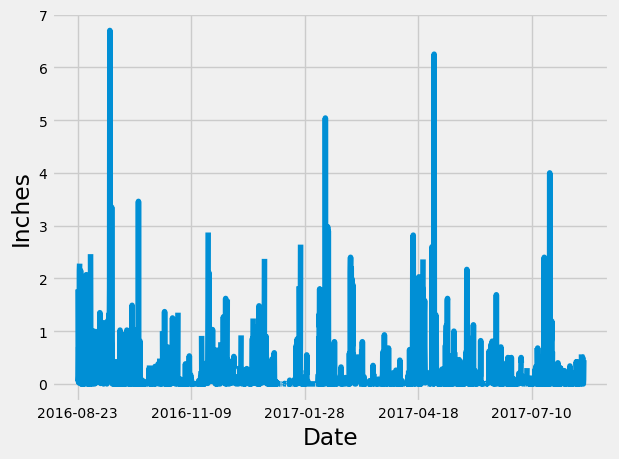

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
data_recent = session.query(Measurement.date, Measurement.prcp).\
                      order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
date = dt.datetime.strptime(data_recent.date, "%Y-%m-%d")
last_date = date.date() - relativedelta(years=1)
last_date
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) >= last_date).\
                all()
data

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dataframe = pd.DataFrame(data, columns = ['Date', 'Precipitation'])
dataframe = dataframe.set_index('Date')

# Sort the dataframe by date
sorted_df = dataframe.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df["Precipitation"].plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()


In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Station).count()
print(stations)

9


In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station,
       func.count(Measurement.station)]

ordered_stations = session.query(*sel).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).\
                    all()

ordered_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

active_station_stats = session.query(*sel).\
                        filter(Measurement.station == ordered_stations[0][0]).\
                        all()

active_station_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

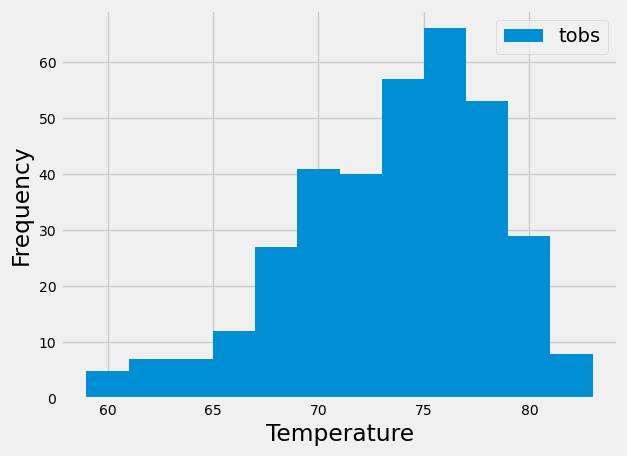

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
                        filter(Measurement.station == ordered_stations[0][0]).\
                        filter(func.strftime("%Y-%m-%d", Measurement.date) >= last_date).\
                        all()

temps = pd.DataFrame(results)
temps.plot.hist(bins =12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()


# Close Session

In [16]:
# Close Session
session.close()